## Regression-Based Classification

#### Table of Contents

* [Preliminaries](#Preliminaries)
* [Binomial Logistic Regression](#Binomial-Logistic-Regression)
    - [Logit Inference](#Logit-Inference)
        - [Logit Marginal Effects](#Logit-Marginal-Effects)
        - [Comparison to LPM](#Comparison-to-LPM)
        - [Logit Regularization](#Logit-Regularization)
    - [Logit Prediction Diagnostics](#Logit-Prediction-Diagnostics)
        - [Logit Null Model](#Logit-Null-Model)
        - [Logit Full Model](#Logit-Full-Model)
        - [Alternative Thresholds](#Alternative-Thresholds)
- [Multinomial Logistic Regression](#Multinomial-Logistic-Regression)
    - [MN Logit Inference](#MN-Logit-Inference)
        - [MN Logit Marginal Effects](#MN-Logit-Marginal-Effects)
        - [MN Logit Regularization](#MN-Logit-Regularization)
    - [MN Logit Prediction Diagnostics](#MN-Logit-Prediction-Diagnostics)
        - [MN Logit Null Model](#MN-Logit-Null-Model)
        - [MN Logit Full Model](#MN-Logit-Full-Model)

***
# Preliminaries
[TOP](#Regression-Based-Classification)

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm # progress bar

import statsmodels.api as sm
from sklearn import linear_model as lm

from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'axes.titlesize': 24,
             'axes.labelsize': 20,
             'xtick.labelsize': 12,
             'ytick.labelsize': 12,
             'figure.figsize': (8, 4.5)})
sns.set_style("white") # for plot_confusion_matrix()

In [4]:
df = pd.read_pickle('C:/Users/hubst/Econ490_group/class_data.pkl')

In [9]:
df_prepped = df.drop(columns = ['urate_bin', 'year', 'GeoName']).join([
    pd.get_dummies(df['urate_bin'], drop_first = True),
    pd.get_dummies(df.year, drop_first = True)    
])


In [10]:
y = df_prepped['pos_net_jobs'].astype(float)
x = df_prepped.drop(columns = 'pos_net_jobs')

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 2/3, random_state = 490)

x_train_std = x_train.apply(lambda x: (x - np.mean(x))/np.std(x), axis = 0)
x_test_std  = x_test.apply(lambda x: (x - np.mean(x))/np.std(x), axis = 0)

x_train_std = sm.add_constant(x_train_std)
x_test_std  = sm.add_constant(x_test_std)
x_train     = sm.add_constant(x_train)
x_test      = sm.add_constant(x_test)

*******
# Binomial Logistic Regression
[TOP](#Regression-Based-Classification)

There are three primary ways to fit a logsitic regression:

- `statsmodels.api.Logit(y, x).fit()`
- `statsmodels.formula.api.logit(data = df, formula = 'y ~ x').fit()`
- `sklearn.linear_model.LogisticRegression().fit(x, y)`

************
## Logit Inference
[TOP](#Regression-Based-Classification)

By now, if you are thinking inference, then you should be thinking `statsmodels`.

In [11]:
fit_logit = sm.Logit(y_train, x_train).fit()

Optimization terminated successfully.
         Current function value: 0.598795
         Iterations 6


In [12]:
fit_logit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:               Logit            Pseudo R-squared: 0.127     
Dependent Variable:  pos_net_jobs     AIC:              40077.0933
Date:                2021-03-02 14:21 BIC:              40312.7651
No. Observations:    33418            Log-Likelihood:   -20011.   
Df Model:            27               LL-Null:          -22913.   
Df Residuals:        33390            LLR p-value:      0.0000    
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      6.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
const             -2.1336   0.1494 -14.2851 0.0000 -2.4263 -1.8409
pct_d_rgdp         0.0155   0.0015  10.3856 0.0000  0.0126  0.0184
emp_estabs         0.0417   0.0030  14.1236 0.0000  0.0359  0.0475
estabs_entry_rate  0.2041   0.0056  36.3848 0.0000  0.1931  0.2151
estabs_exit_rate  -0.1647   0.0061 -26.8399 0.0000 -0.1767 -0.1527
pop                0.0000   0.0000   2.0681 0.0386  0.0000  0.0000
pop_pct_black     -0.0033   0.0009  -3.5175 0.0004 -0.0052 -0.0015
pop_pct_hisp       0.0059   0.0010   5.9288 0.0000  0.0039  0.0078
lfpr               0.0019   0.0014   1.3754 0.1690 -0.0008  0.0047
density            0.0000   0.0000   1.0236 0.3060 -0.0000  0.0000
lower              0.3610   0.0338  10.6966 0.0000  0.2949  0.4272
similar            0.1662   0.0359   4.6308 0.0000  0.0959  0.2366
2003               1.0495   0.0689  15.2345 0.0000  0.9145  1.1845
2004               1.3234   0.0706  18.7548 0.0000  1.1851  1.4617
2005               1.2072   0.0720  16.7553 0.0000  1.0660  1.3484
2006               1.7648   0.0758  23.2861 0.0000  1.6162  1.9133
2007               0.5726   0.0681   8.4049 0.0000  0.4391  0.7062
2008               0.8626   0.0690  12.5012 0.0000  0.7273  0.9978
2009              -0.5327   0.0827  -6.4412 0.0000 -0.6948 -0.3706
2010               0.2174   0.0717   3.0336 0.0024  0.0769  0.3578
2011               1.3064   0.0703  18.5921 0.0000  1.1686  1.4441
2012               1.5542   0.0722  21.5354 0.0000  1.4127  1.6956
2013               1.2692   0.0709  17.9033 0.0000  1.1303  1.4082
2014               1.5313   0.0727  21.0515 0.0000  1.3887  1.6739
2015               1.6098   0.0737  21.8320 0.0000  1.4653  1.7543
2016               1.3157   0.0721  18.2485 0.0000  1.1744  1.4570
2017               1.1677   0.0705  16.5515 0.0000  1.0294  1.3060
2018               1.4274   0.0728  19.6171 0.0000  1.2848  1.5700
==================================================================

"""

***********
### Logit Marginal Effects 
[TOP](#Regression-Based-Classification)

In [13]:
# There is no summary2() method for marginal effects
fit_logit.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:           pos_net_jobs
Method:                          dydx
At:                           overall
=====================================================================================
                       dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
pct_d_rgdp            0.0032      0.000     10.444      0.000       0.003       0.004
emp_estabs            0.0086      0.001     14.278      0.000       0.007       0.010
estabs_entry_rate     0.0421      0.001     39.190      0.000       0.040       0.044
estabs_exit_rate     -0.0340      0.001    -27.918      0.000      -0.036      -0.032
pop                2.054e-08   9.93e-09      2.069      0.039    1.08e-09       4e-08
pop_pct_black        -0.0007      0.000     -3.520      0.000      -0.001      -0.000
pop_pct_hisp          0.0012      0.000      5.939      0.000       0.001       0.002
lfpr                  0.0004      0.000      1.376      0.169      -0.000       0.001
density            1.698e-06   1.66e-06      1.024      0.306   -1.55e-06    4.95e-06
lower                 0.0745      0.007     10.763      0.000       0.061       0.088
similar               0.0343      0.007      4.637      0.000       0.020       0.049
2003                  0.2167      0.014     15.438      0.000       0.189       0.244
2004                  0.2732      0.014     19.134      0.000       0.245       0.301
2005                  0.2492      0.015     17.026      0.000       0.221       0.278
2006                  0.3643      0.015     24.002      0.000       0.335       0.394
2007                  0.1182      0.014      8.438      0.000       0.091       0.146
2008                  0.1781      0.014     12.609      0.000       0.150       0.206
2009                 -0.1100      0.017     -6.451      0.000      -0.143      -0.077
2010                  0.0449      0.015      3.035      0.002       0.016       0.074
2011                  0.2697      0.014     18.958      0.000       0.242       0.298
2012                  0.3208      0.015     22.110      0.000       0.292       0.349
2013                  0.2620      0.014     18.231      0.000       0.234       0.290
2014                  0.3161      0.015     21.587      0.000       0.287       0.345
2015                  0.3323      0.015     22.429      0.000       0.303       0.361
2016                  0.2716      0.015     18.597      0.000       0.243       0.300
2017                  0.2411      0.014     16.809      0.000       0.213       0.269
2018                  0.2947      0.015     20.051      0.000       0.266       0.323
=====================================================================================
"""

******
### Comparison to LPM 
[TOP](#Regression-Based-Classification)

For the sake of not exploding this notebook with summaries, let's use a simplier model:

In [14]:
sm.Logit(y_train, x_train[['const', 'pct_d_rgdp', 'estabs_exit_rate']]).fit().get_margeff().summary()

Optimization terminated successfully.
         Current function value: 0.670589
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:           pos_net_jobs
Method:                          dydx
At:                           overall
====================================================================================
                      dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
pct_d_rgdp           0.0057      0.000     16.916      0.000       0.005       0.006
estabs_exit_rate    -0.0286      0.001    -26.454      0.000      -0.031      -0.026
====================================================================================
"""

In [15]:
sm.OLS(y_train, x_train[['const', 'pct_d_rgdp', 'estabs_exit_rate']]).fit().params

const               0.798882
pct_d_rgdp          0.004872
estabs_exit_rate   -0.027791
dtype: float64

While these values are not identical, they are pretty close to one another. This is because OLS is always a first order approximation. Think/thank Taylor Series!

*********
### Logit Regularization 
[TOP](#Regression-Based-Classification)

We can also perform regularization, much like OLS:

In [16]:
%%time
param_grid = {
    'C': 10.0**np.arange(-5, -1, step = 1),
    'l1_ratio':  np.arange(0, 1, step = 0.1)
}

lr_cv = lm.LogisticRegression(penalty = 'elasticnet', solver = 'saga',
                              max_iter = 1e3, random_state = 490)
grid_search = GridSearchCV(lr_cv, param_grid, 
                          cv = 5, 
                          scoring = 'accuracy',
                          n_jobs = 10)
grid_search.fit(x_train_std, y_train)
best = grid_search.best_params_
best

Wall time: 10.7 s


{'C': 0.01, 'l1_ratio': 0.2}

# $C = \frac{1}{\alpha}$ 

In [17]:
# You will get convergence warnings
# They are due to difficulty converging
# We can address this by accepting some error
# with our qc_tol
# See below
fit_logit_reg = sm.Logit(y_train, x_train_std
                        ).fit_regularized(alpha = 1/best['C'],
                                          L1_wt = best['l1_ratio'],
                                          qc_tol = 1e3)
fit_logit_reg.params

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6141965372354353
            Iterations: 45
            Function evaluations: 46
            Gradient evaluations: 45


const                0.246821
pct_d_rgdp           0.120624
emp_estabs           0.173485
estabs_entry_rate    0.542312
estabs_exit_rate    -0.410774
pop                  0.031311
pop_pct_black       -0.037813
pop_pct_hisp         0.072487
lfpr                 0.016614
density              0.003289
lower                0.140961
similar              0.033833
2003                 0.094805
2004                 0.156656
2005                 0.120683
2006                 0.256414
2007                 0.000000
2008                 0.044686
2009                -0.254350
2010                -0.084895
2011                 0.143128
2012                 0.198579
2013                 0.134284
2014                 0.194389
2015                 0.211146
2016                 0.145626
2017                 0.113280
2018                 0.168774
dtype: float64

****************
## Logit Prediction Diagnostics
[TOP](#Regression-Based-Classification)

Here we are going to look at how to produce

- accuracy
- visualizing optimal threshold values
- the confusion matrix

In [18]:
fit_logit.predict(x_test).describe()

count    16709.000000
mean         0.562992
std          0.199280
min          0.000559
25%          0.435836
50%          0.597314
75%          0.712688
max          0.999840
dtype: float64

As you can see from the summary of `yhat`, `statsmodels` predicts the probabilities. **How do we know that to be true?**

***

To produce the **prediction** diagnostics, it is easier to use `sklearn`. 

********
### Logit Null Model
[TOP](#Regression-Based-Classification)

In classification, the **null model** is simply predicting the most frequently occuring class.

In [19]:
y_train.value_counts()

1.0    18754
0.0    14664
Name: pos_net_jobs, dtype: int64

In [20]:
acc_logit_null = np.mean(y_test == 1)
acc_logit_null

0.562391525525166

****
### Logit Full Model
[TOP](#Regression-Based-Classification)

For the sake of exposition, we are simply going to use all of the features.

In [21]:
fit_logit_sk = lm.LogisticRegression().fit(x_train, y_train)

In [22]:
yhat = fit_logit_sk.predict(x_test)

In [23]:
acc_logit = np.mean(yhat == y_test)
acc_logit

0.562391525525166

In [24]:
(acc_logit - acc_logit_null)/acc_logit_null*100

0.0

Let's take a look at the confusion matrix.

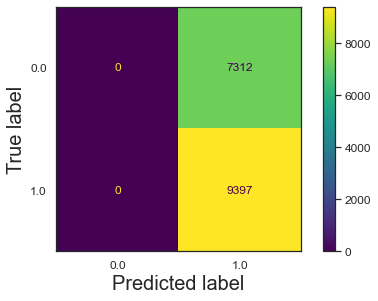

In [25]:
plot_confusion_matrix(fit_logit_sk, x_test, y_test)
plt.show()

We may have to consider changing thresholds.

***
### Alternative Thresholds
[TOP](#Regression-Based-Classification)

We can use `sklearn` to predict probabilities. 
It will produce a column for each class you have.
In this case, we have two classes. 

In [26]:
yhat_proba = fit_logit_sk.predict_proba(x_test)
yhat_proba[range(5), ]

array([[0.43727221, 0.56272779],
       [0.42788686, 0.57211314],
       [0.43320042, 0.56679958],
       [0.45279396, 0.54720604],
       [0.43947118, 0.56052882]])

In [27]:
min(yhat_proba[:, 1])

0.5186664255680362

The minimum probability of being in a county with positive net job creation is greater than the default threshold of 50%! Indeed! We will have to cross-validate the threshold.

There is no built in function to cross-validate the threshold for logit. 
We will have to manually set up the loops.

In [28]:
train = pd.merge(y_train, x_train, left_index = True, right_index = True)
kf = KFold(n_splits = 5, random_state = 490, shuffle = True)
alpha = np.round(    np.arange(0.5, 0.7, step = 0.01), 2    )

In [29]:
accuracy = {}

for a in tqdm(alpha):
    acc = []
    for trn, tst in kf.split(train):
        yhat = (lm.LogisticRegression(solver = 'liblinear'
                                      ).fit(train.iloc[trn, 1:], train.iloc[trn, 0]
                                           ).predict_proba(train.iloc[tst, 1:])[:, 1] > a)*1
        acc.append(np.mean(yhat == train.iloc[tst, 0]))
    accuracy[a] = np.mean(acc)
    
accuracy

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.28it/s]


{0.5: 0.5890237007303382,
 0.51: 0.5933327978409808,
 0.52: 0.5981805796624123,
 0.53: 0.6037165631814263,
 0.54: 0.6054819014778245,
 0.55: 0.6013224153785524,
 0.56: 0.5841161595742137,
 0.57: 0.5613143176237966,
 0.58: 0.5409958214582531,
 0.59: 0.5271705372107636,
 0.6: 0.5145423022392266,
 0.61: 0.5055649251792713,
 0.62: 0.4992807433278593,
 0.63: 0.493415602151748,
 0.64: 0.4865929863217523,
 0.65: 0.48087755465894916,
 0.66: 0.4772866530859359,
 0.67: 0.47414464723008515,
 0.68: 0.47028453986118207,
 0.69: 0.46714254296005314}

In [30]:
print('max accuracy at alpha = %s' % max(accuracy, key = accuracy.get))

max accuracy at alpha = 0.54


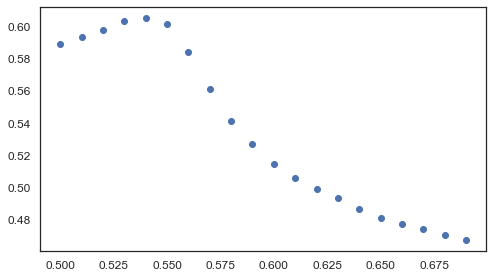

In [31]:
plt.scatter(accuracy.keys(), accuracy.values())
plt.show()

The maximum is $\alpha=0.54$. However, from the figure, it looks like we can choose either 0.54 or 0.55. Since the accuracy drops off quickly to the right, we may be safer using 0.54.

Because we have adjusted the threshold, we need to manually calculate the confusion matrix.

In [32]:
best_alpha = max(accuracy, key = accuracy.get)
yhat_class = (yhat_proba[:, 1] >= best_alpha)*1

TN = sum(((y_test == yhat_class) & (y_test == 0))*1)
FP = sum(((y_test != yhat_class) & (y_test == 0))*1)
FN = sum(((y_test != yhat_class) & (y_test == 1))*1)
TP = sum(((y_test == yhat_class) & (y_test == 1))*1)

print(np.array([[TN, FP],[FN, TP]]))
print((TN + TP)/(TN + FN + FP + TP))
acc_logit_54 = np.mean(yhat_class == y_test)
print(acc_logit_54, '\n')

[[ 157 7155]
 [ 122 9275]]
0.5644862050392004
0.5644862050392004 



Finally, we can compute the percent improvement from the null model.

In [33]:
round(  (acc_logit_54 - acc_logit_null)/acc_logit_null*100, 2)

0.37

It looks we have improved our prediction by just over 8%.

************
# Multinomial Logistic Regression 
[TOP](#Regression-Based-Classification)

We need to adjust features and labels to retreive our multiclass label. It is easier to start from scratch. 

Because logisitc functions struggle with many dummy variables, we are going to simply drop the fixed effects.

We will be converting the categorical label to a `category` type of object prior to splitting. This is to ensure consistent labels in the training and testing data.

In [34]:
df_prepped = df.drop(columns = 'year')
df_prepped['urate_bin'] = df_prepped['urate_bin'].astype('category')
df_prepped.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 50127 entries, (1001, 2002) to (56045, 2018)
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   GeoName            50127 non-null  object  
 1   pct_d_rgdp         50127 non-null  float64 
 2   urate_bin          50127 non-null  category
 3   pos_net_jobs       50127 non-null  int32   
 4   emp_estabs         50127 non-null  float64 
 5   estabs_entry_rate  50127 non-null  float64 
 6   estabs_exit_rate   50127 non-null  float64 
 7   pop                50127 non-null  float64 
 8   pop_pct_black      50127 non-null  float64 
 9   pop_pct_hisp       50127 non-null  float64 
 10  lfpr               50127 non-null  float64 
 11  density            50127 non-null  float64 
dtypes: category(1), float64(9), int32(1), object(1)
memory usage: 5.6+ MB


In [35]:
df_prepped['urate_bin'].head()

fips  year
1001  2002     lower
      2003     lower
      2004     lower
      2005    higher
      2006    higher
Name: urate_bin, dtype: category
Categories (3, object): ['higher', 'lower', 'similar']

In [36]:
df_prepped['urate_bin'].cat.codes.head()

fips  year
1001  2002    1
      2003    1
      2004    1
      2005    0
      2006    0
dtype: int8

In [40]:
y = df_prepped['urate_bin']
x = df_prepped.drop(columns = ['urate_bin', 'GeoName'])

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 2/3, random_state = 490)

x_train_std = x_train.apply(lambda x: (x - np.mean(x))/np.std(x), axis = 0)
x_test_std  = x_test.apply(lambda x: (x - np.mean(x))/np.std(x), axis = 0)

x_train_std = sm.add_constant(x_train_std)
x_test_std  = sm.add_constant(x_test_std)
x_train     = sm.add_constant(x_train)
x_test      = sm.add_constant(x_test)

*****************
## MN Logit Inference
[TOP](#Regression-Based-Classification)

In [41]:
fit_mnlogit = sm.MNLogit(y_train, x_train).fit(maxiter = 150)

Optimization terminated successfully.
         Current function value: 0.903926
         Iterations 6


In [42]:
fit_mnlogit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: MNLogit
==================================================================
Model:               MNLogit          Pseudo R-squared: 0.131     
Dependent Variable:  urate_bin        AIC:              60458.7757
Date:                2021-03-02 14:29 BIC:              60643.9464
No. Observations:    33418            Log-Likelihood:   -30207.   
Df Model:            20               LL-Null:          -34744.   
Df Residuals:        33396            LLR p-value:      0.0000    
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      6.0000                                       
------------------------------------------------------------------
  urate_bin = 0    Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
            const -8.3683   0.1672 -50.0637 0.0000 -8.6959 -8.0407
       pct_d_rgdp  0.0072   0.0016   4.4722 0.0000  0.0040  0.0103
     pos_net_jobs  0.1640   0.0295   5.5591 0.0000  0.1062  0.2218
       emp_estabs  0.0171   0.0033   5.1468 0.0000  0.0106  0.0236
estabs_entry_rate -0.0323   0.0054  -5.9356 0.0000 -0.0429 -0.0216
 estabs_exit_rate -0.0973   0.0066 -14.7237 0.0000 -0.1103 -0.0844
              pop  0.0000   0.0000   1.7132 0.0867 -0.0000  0.0000
    pop_pct_black -0.0155   0.0013 -11.6562 0.0000 -0.0181 -0.0129
     pop_pct_hisp  0.0134   0.0011  12.4767 0.0000  0.0113  0.0155
             lfpr  0.1174   0.0018  64.2527 0.0000  0.1138  0.1210
          density  0.0000   0.0000   1.6576 0.0974 -0.0000  0.0000
------------------------------------------------------------------
  urate_bin = 1    Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
            const -2.5876   0.1636 -15.8190 0.0000 -2.9082 -2.2670
       pct_d_rgdp  0.0003   0.0019   0.1329 0.8943 -0.0036  0.0041
     pos_net_jobs  0.0684   0.0328   2.0866 0.0369  0.0042  0.1327
       emp_estabs  0.0348   0.0035   9.9104 0.0000  0.0280  0.0417
estabs_entry_rate -0.0460   0.0063  -7.2651 0.0000 -0.0584 -0.0336
 estabs_exit_rate -0.0642   0.0074  -8.6752 0.0000 -0.0788 -0.0497
              pop  0.0000   0.0000   3.9790 0.0001  0.0000  0.0000
    pop_pct_black -0.0105   0.0012  -8.8689 0.0000 -0.0128 -0.0081
     pop_pct_hisp  0.0008   0.0013   0.6447 0.5191 -0.0017  0.0034
             lfpr  0.0311   0.0018  16.9901 0.0000  0.0275  0.0347
          density  0.0000   0.0000   1.8560 0.0634 -0.0000  0.0000
==================================================================

"""

In [43]:
y_train.cat.categories

Index(['higher', 'lower', 'similar'], dtype='object')

We can see that the baseline class is 2, which is `similar`.

We can change the category levels if we wish:

In [44]:
fit_mnlogit = sm.MNLogit(y_train.cat.set_categories(new_categories = ['lower', 'similar', 'higher']),
                                                    x_train).fit(maxiter = 150)
fit_mnlogit.summary2()

Optimization terminated successfully.
         Current function value: 0.903926
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: MNLogit
==================================================================
Model:               MNLogit          Pseudo R-squared: 0.131     
Dependent Variable:  urate_bin        AIC:              60458.7757
Date:                2021-03-02 14:29 BIC:              60643.9464
No. Observations:    33418            Log-Likelihood:   -30207.   
Df Model:            20               LL-Null:          -34744.   
Df Residuals:        33396            LLR p-value:      0.0000    
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      6.0000                                       
------------------------------------------------------------------
  urate_bin = 0    Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
            const  5.7807   0.1909  30.2756 0.0000  5.4065  6.1549
       pct_d_rgdp -0.0069   0.0020  -3.5133 0.0004 -0.0108 -0.0031
     pos_net_jobs -0.0956   0.0347  -2.7529 0.0059 -0.1636 -0.0275
       emp_estabs  0.0178   0.0036   4.8653 0.0000  0.0106  0.0249
estabs_entry_rate -0.0137   0.0067  -2.0400 0.0413 -0.0269 -0.0005
 estabs_exit_rate  0.0331   0.0081   4.1048 0.0000  0.0173  0.0489
              pop  0.0000   0.0000   2.4715 0.0135  0.0000  0.0000
    pop_pct_black  0.0051   0.0015   3.2881 0.0010  0.0021  0.0081
     pop_pct_hisp -0.0126   0.0013  -9.5398 0.0000 -0.0152 -0.0100
             lfpr -0.0863   0.0021 -42.0772 0.0000 -0.0903 -0.0823
          density  0.0000   0.0000   0.2169 0.8283 -0.0000  0.0000
------------------------------------------------------------------
  urate_bin = 1    Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
            const  8.3683   0.1672  50.0637 0.0000  8.0407  8.6959
       pct_d_rgdp -0.0072   0.0016  -4.4722 0.0000 -0.0103 -0.0040
     pos_net_jobs -0.1640   0.0295  -5.5591 0.0000 -0.2218 -0.1062
       emp_estabs -0.0171   0.0033  -5.1468 0.0000 -0.0236 -0.0106
estabs_entry_rate  0.0323   0.0054   5.9356 0.0000  0.0216  0.0429
 estabs_exit_rate  0.0973   0.0066  14.7237 0.0000  0.0844  0.1103
              pop -0.0000   0.0000  -1.7132 0.0867 -0.0000  0.0000
    pop_pct_black  0.0155   0.0013  11.6562 0.0000  0.0129  0.0181
     pop_pct_hisp -0.0134   0.0011 -12.4767 0.0000 -0.0155 -0.0113
             lfpr -0.1174   0.0018 -64.2527 0.0000 -0.1210 -0.1138
          density -0.0000   0.0000  -1.6576 0.0974 -0.0000  0.0000
==================================================================

"""

***********
### MN Logit Marginal Effects
[TOP](#Regression-Based-Classification)

In [45]:
fit_mnlogit.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       MNLogit Marginal Effects      
=====================================
Dep. Variable:              urate_bin
Method:                          dydx
At:                           overall
=====================================================================================
  urate_bin=lower      dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
pct_d_rgdp            0.0013      0.000      4.821      0.000       0.001       0.002
pos_net_jobs          0.0257      0.005      5.158      0.000       0.016       0.036
emp_estabs            0.0009      0.001      1.687      0.092      -0.000       0.002
estabs_entry_rate    -0.0030      0.001     -3.221      0.001      -0.005      -0.001
estabs_exit_rate     -0.0138      0.001    -12.196      0.000      -0.016      -0.012
pop                2.883e-09   7.59e-09      0.380      0.704    -1.2e-08    1.78e-08
pop_pct_black        -0.0022      0.000     -9.258      0.000      -0.003      -0.002
pop_pct_hisp          0.0024      0.000     13.395      0.000       0.002       0.003
lfpr                  0.0195      0.000     82.444      0.000       0.019       0.020
density            1.585e-06   1.33e-06      1.192      0.233   -1.02e-06    4.19e-06
-------------------------------------------------------------------------------------
urate_bin=similar      dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
pct_d_rgdp           -0.0004      0.000     -1.590      0.112      -0.001    9.68e-05
pos_net_jobs         -0.0004      0.004     -0.082      0.935      -0.009       0.008
emp_estabs            0.0040      0.000      8.686      0.000       0.003       0.005
estabs_entry_rate    -0.0047      0.001     -5.418      0.000      -0.006      -0.003
estabs_exit_rate     -0.0032      0.001     -3.202      0.001      -0.005      -0.001
pop                2.339e-08   6.01e-09      3.891      0.000    1.16e-08    3.52e-08
pop_pct_black        -0.0005      0.000     -3.189      0.001      -0.001      -0.000
pop_pct_hisp         -0.0007      0.000     -4.183      0.000      -0.001      -0.000
lfpr                 -0.0029      0.000    -13.336      0.000      -0.003      -0.002
density            1.425e-06   1.04e-06      1.368      0.171   -6.16e-07    3.47e-06
-------------------------------------------------------------------------------------
 urate_bin=higher      dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
pct_d_rgdp           -0.0009      0.000     -2.974      0.003      -0.001      -0.000
pos_net_jobs         -0.0254      0.005     -4.858      0.000      -0.036      -0.015
emp_estabs           -0.0049      0.001     -8.464      0.000      -0.006      -0.004
estabs_entry_rate     0.0077      0.001      7.943      0.000       0.006       0.010
estabs_exit_rate      0.0170      0.001     14.858      0.000       0.015       0.019
pop               -2.627e-08   8.82e-09     -2.979      0.003   -4.36e-08   -8.98e-09
pop_pct_black         0.0027      0.000     13.314      0.000       0.002       0.003
pop_pct_hisp         -0.0017      0.000     -8.535      0.000      -0.002      -0.001
lfpr                 -0.0167      0.000    -66.917      0.000      -0.017      -0.016
density            -3.01e-06   1.54e-06     -1.955      0.051   -6.03e-06    7.48e-09
=====================================================================================
"""

*************
### MN Logit Regularization 
[TOP](#Regression-Based-Classification)

In [46]:
%%time
param_grid = {
    'C': 10.0**np.arange(-5, -1, step = 1),
    'l1_ratio':  np.arange(0, 1, step = 0.1)
}

lr_cv = lm.LogisticRegression(penalty = 'elasticnet', solver = 'saga',
                              max_iter = 1e3, random_state = 490)
grid_search = GridSearchCV(lr_cv, param_grid, 
                          cv = 5, 
                          scoring = 'accuracy',
                          n_jobs = 10)
grid_search.fit(x_train_std, y_train)
best = grid_search.best_params_
best

Wall time: 11.8 s


{'C': 0.01, 'l1_ratio': 0.9}

# $C = \frac{1}{\alpha}$

In [47]:
# You will get convergence warnings
# They are due to difficulty converging
# We can address this by accepting some error
# with our qc_tol
# See below
fit_logit_reg = sm.MNLogit(y_train, x_train_std
                          ).fit_regularized(alpha = 1/best['C'],
                                            L1_wt = best['l1_ratio'],
                                            qc_tol = 1e3)
fit_logit_reg.params

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.9163228046383791
            Iterations: 46
            Function evaluations: 47
            Gradient evaluations: 46


,0,1
const,-0.218634,-0.747939
pct_d_rgdp,0.047803,0.000000
pos_net_jobs,0.056821,0.004691
emp_estabs,0.056787,0.139618
estabs_entry_rate,-0.063320,-0.095805
estabs_exit_rate,-0.229619,-0.142851
pop,0.007940,0.044575
pop_pct_black,-0.185751,-0.120879
pop_pct_hisp,0.156680,0.000000
lfpr,1.242667,0.315184


From here, you can decide whether or not to keep variables if you wish to refit without regularization.
As a rule of thumb, drop features that are 50% zero across classes.

***
## MN Logit Prediction Diagnostics
[TOP](#Regression-Based-Classification)

We will proceed as we did for the binomial logistic regression.
We will first fit the null model and then compare it to another model.

********
### MN Logit Null Model
[TOP](#Regression-Based-Classification)

In [48]:
y_train.value_counts()

higher     14653
lower      12665
similar     6100
Name: urate_bin, dtype: int64

We can see that the largest grouping of counties have much higher than national unemployment rates.
We will predict that class.

In [49]:
acc_mnlogit_null = np.mean(y_test == 'higher')
acc_mnlogit_null

0.4348554671135316

*******
### MN Logit Full Model
[TOP](#Regression-Based-Classification)

In [50]:
fit_mnlogit_sk = lm.LogisticRegression(solver = 'liblinear').fit(x_train, y_train)

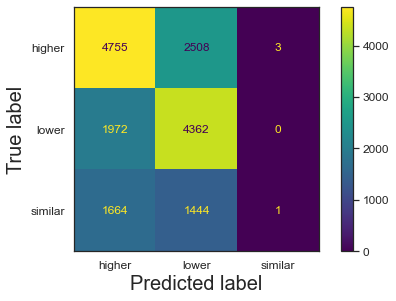

In [51]:
plot_confusion_matrix(fit_mnlogit_sk, x_test, y_test)
plt.show()

It looks like we are having trouble predicting the county unemployment rate similar to the national.

Let's take a look at the overall accuracy.

In [52]:
yhat = fit_mnlogit_sk.predict(x_test)
acc_mnlogit = np.mean(yhat == y_test)
acc_mnlogit

0.5456939373990065

Yikes.

In [54]:
round(100*(acc_mnlogit - acc_mnlogit_null)/acc_mnlogit_null, 2)

25.49

Not a bad improvement, but remember that we are only getting it correct barely more than 50% of the time.